In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import models,layers
from sklearn import preprocessing 
# from keras.optimizers import Adam
import keras

from skimage.measure import block_reduce
%matplotlib inline

2023-10-13 15:00:22.247026: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 15:00:22.291493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-13 15:00:22.293960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 15:00:23.113922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["tf_gpu_allocator"]="cuda_malloc_async"

In [3]:
image_data= np.load("/home/yash/Downloads/images-001.npy")
image_data
image_labels=np.load("/home/yash/Downloads/labels.npy")
image_data.shape

(17736, 256, 256, 3)

(array([1081., 1853., 2645., 2027.,  334., 2043., 1829., 2628., 1423.,
        1873.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

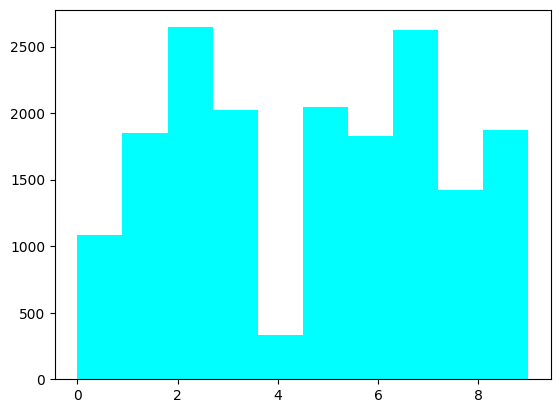

In [4]:

plt.hist(image_labels, color='cyan')

In [5]:
a=block_reduce(image_data,block_size=(1,8,8,1),func=np.mean)
a.shape

(17736, 32, 32, 3)

In [6]:
a=a/256

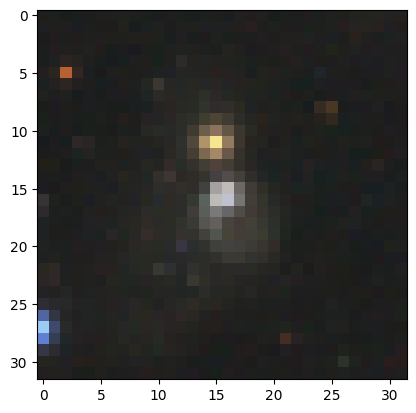

In [7]:
plt.imshow(a[1])

In [8]:
np.unique(image_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

image_data_reshape=image_data.reshape(-1,196608)
image_data[0]
image_data_reshape
df =pd.DataFrame(image_data_reshape)
df.describe
plt.imshow(df[1,])


In [9]:
image_data.shape

(17736, 256, 256, 3)

In [10]:
a.shape

(17736, 32, 32, 3)

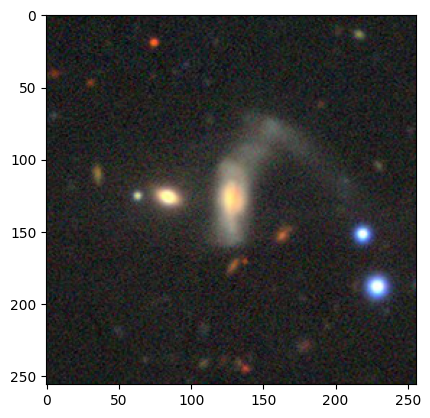

In [11]:
plt.imshow(image_data[0])

In [12]:
X_train,X_test,Y_train,Y_test=train_test_split(a,image_labels,test_size=0.1,random_state=1)
# X_train,X_test,Y_train,Y_test=train_test_split(image_data,image_labels,test_size=0.2)
tensor_Xtrain = tf.convert_to_tensor(X_train)
tensor_Xtest = tf.convert_to_tensor(X_test)
tensor_Ytrain = tf.convert_to_tensor(Y_train)
tensor_Ytest = tf.convert_to_tensor(Y_test)


2023-10-13 15:01:01.713770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-13 15:01:01.714380: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-10-13 15:01:01.716255: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 392282112 exceeds 10% of free system memory.


In [13]:
Y_train.shape


(15962,)

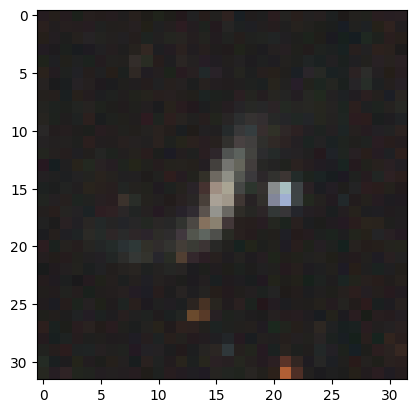

In [14]:
plt.imshow(X_train[0])

In [15]:
model_augmentaion = models.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.50),
    layers.experimental.preprocessing.RandomFlip(mode="vertical")
])

In [16]:


model_cnn = models.Sequential([
        model_augmentaion,
        layers.Conv2D(filters=16,kernel_size=(8,8),activation='relu',input_shape=(32,32,3)),#,strides=(1,1),use_bias=True
        layers.Dropout(0.2),
        layers.MaxPool2D((2,2),padding='same'),
        layers.Conv2D(filters=32,kernel_size=(2,2),activation='relu'),#,use_bias=True
        layers.MaxPool2D((2,2),padding ='same'), 
        layers.Flatten(),
        layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(l=0.01)),
        layers.Dropout(0.4),
        layers.Dense(170,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(112,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(75,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dropout(0.2),
        layers.Dense(10,activation='softmax')
        ])

opt =tf.keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(optimizer=opt,
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy',]
#     tf.keras.metrics.sparse_categorical_accuracy
    )

In [17]:
model_cnn.fit(tensor_Xtrain,tensor_Ytrain,epochs=10,verbose=1,batch_size=256,validation_data=(tensor_Xtest,tensor_Ytest),)
accuracy_mod=model_cnn.evaluate(tensor_Xtest,tensor_Ytest)

Epoch 1/10
63/63 [==============================] - 6s 76ms/step - loss: 37.8977 - accuracy: 0.1523 - val_loss: 4.4649 - val_accuracy: 0.1894
Epoch 2/10
63/63 [==============================] - 5s 78ms/step - loss: 3.0438 - accuracy: 0.1882 - val_loss: 2.4697 - val_accuracy: 0.2520
Epoch 3/10
63/63 [==============================] - 5s 83ms/step - loss: 2.4485 - accuracy: 0.2212 - val_loss: 2.3883 - val_accuracy: 0.2593
Epoch 4/10
63/63 [==============================] - 5s 79ms/step - loss: 2.3931 - accuracy: 0.2258 - val_loss: 2.3364 - val_accuracy: 0.2649
Epoch 5/10
63/63 [==============================] - 5s 76ms/step - loss: 2.3772 - accuracy: 0.2278 - val_loss: 2.3340 - val_accuracy: 0.2655
Epoch 6/10
63/63 [==============================] - 5s 73ms/step - loss: 2.3595 - accuracy: 0.2346 - val_loss: 2.3408 - val_accuracy: 0.2616
Epoch 7/10
63/63 [==============================] - 5s 73ms/step - loss: 2.3461 - accuracy: 0.2368 - val_loss: 2.3041 - val_accuracy: 0.2610
Epoch 8/10
6

In [18]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 16)        3088      
                                                                 
 dropout (Dropout)           (None, 25, 25, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                 

In [19]:
accuracy_mod

[2.289226531982422, 0.2683201730251312]

[1.8099560737609863, 0.5332581996917725]

In [20]:
a.shape

(17736, 32, 32, 3)

In [21]:
a_resahpe=a.reshape(17736,3072)
a_resahpe.shape

(17736, 3072)

In [22]:
from sklearn.model_selection import StratifiedKFold
fold = StratifiedKFold(n_splits=5)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=3)

In [23]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="minority")
X_smote,Y_smote =smote.fit_resample(a_resahpe,image_labels)

In [24]:
X_smote=X_smote.reshape(20047,32,32,3)

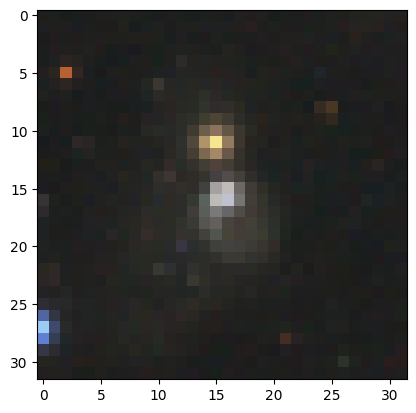

In [25]:
plt.imshow(X_smote[1])

In [26]:
X_smote.shape

(20047, 32, 32, 3)

(array([1081., 1853., 2645., 2027., 2645., 2043., 1829., 2628., 1423.,
        1873.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

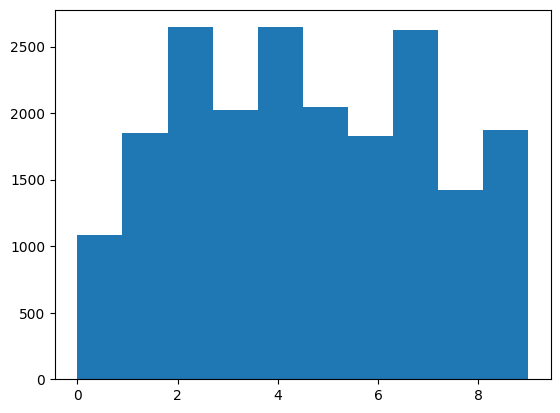

In [27]:

plt.hist(Y_smote)

In [28]:
image_data_smote = np.concatenate((a,X_smote ))
image_labels_smote = np.concatenate((image_labels,Y_smote ))

(array([2162., 3706., 5290., 4054., 2979., 4086., 3658., 5256., 2846.,
        3746.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

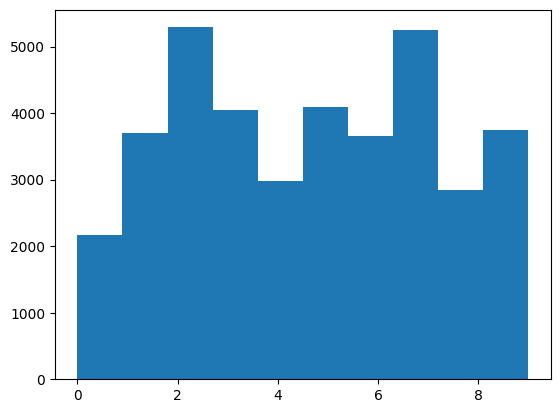

In [29]:
plt.hist(image_labels_smote)

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="minority")
X_smote,Y_smote =smote.fit_resample(image_data_smote,image_labels_smote)

ValueError: Found array with dim 4. SMOTE expected <= 2.

In [ ]:

image_data_smote = np.concatenate((image_data_smote,X_smote ))
image_labels_smote = np.concatenate((image_labels_smote,Y_smote ))

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(image_data_smote,image_labels_smote,test_size=0.1,random_state=1)
# X_train,X_test,Y_train,Y_test=train_test_split(image_data,image_labels,test_size=0.2)
tensor_Xtrain = tf.convert_to_tensor(X_train)
tensor_Xtest = tf.convert_to_tensor(X_test)
tensor_Ytrain = tf.convert_to_tensor(Y_train)
tensor_Ytest = tf.convert_to_tensor(Y_test)


2023-10-12 21:15:52.517358: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 835682304 exceeds 10% of free system memory.


model_cnn.fit(tensor_Xtrain,tensor_Ytrain,epochs=1000,verbose=1,batch_size=3512,validation_data=(tensor_Xtest,tensor_Ytest))
accuracy_mod=model_cnn.evaluate(tensor_Xtest,tensor_Ytest)